In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy.random import randint
from sklearn.neighbors import NearestNeighbors

%matplotlib inline

In [2]:
# Load and prepare data
data = pd.read_csv("../../data/cyclohexane.csv", header=0)

X = data.drop("solvent", axis=1)
best_sample = X.iloc[0].to_numpy().reshape(-1, 1)

In [3]:
plt.rcParams['font.size'] = 12
xticks = np.linspace(0, X.shape[1]-1, 6, dtype=int)
xlabels = X.columns[xticks].astype(float).astype(int).values

def build_plot():
    fig, ax = plt.subplots(figsize=(8, 4))
    plt.gca().spines['right'].set_color('none')
    plt.gca().spines['top'].set_color('none')
    plt.ylabel("Intensity (a.u)")
    plt.xlabel("Raman Shift (cm$^{-1}$)")
    plt.xlim([-20, 3296])
    plt.xticks(xticks, labels=xlabels)
    plt.grid(False)
    
    return fig

## Example Raw Spectra

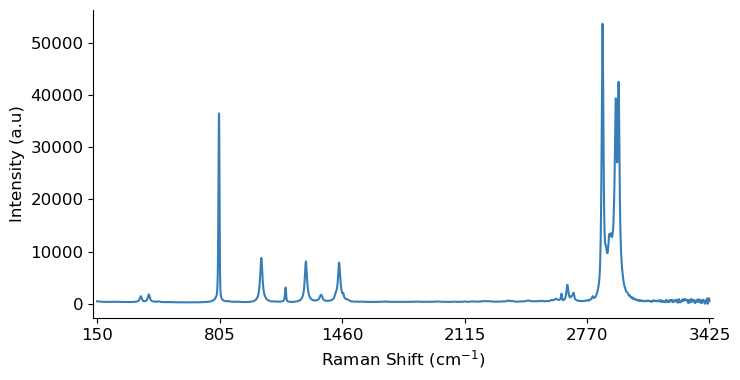

In [4]:
_ = build_plot()
plt.plot(best_sample, "#377eb8");

## Example Batch of Raw Spectra

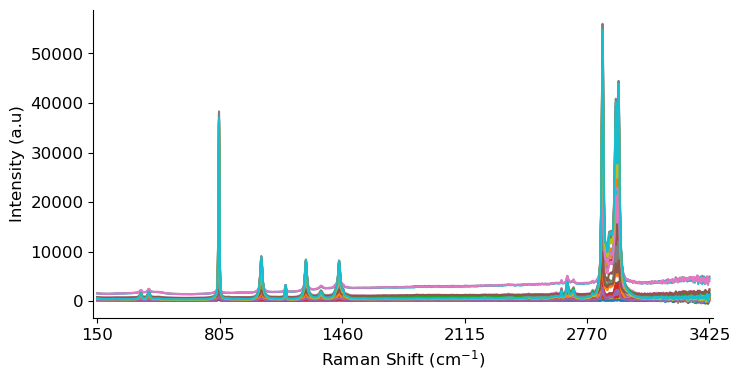

In [5]:
_ = build_plot()
plt.plot(X.iloc[:50, :].T); # semicolon to suppress matplotlib output, can also assign it as _ = plot(.)

In [6]:
def calculate_class_priors(y, print_counts=True):
    """
    Calculates the class prior probabilities for binary classes.

    Args:
        y (array-like):
            Class labels.
        print_counts (bool):
            Print class counts

    Returns:
        dict: 
            Class counts of minority class and majority class.
    """
    # Convert input to NumPy array
    y = np.array(y)
    
    # Get unique classes and their counts
    unique, counts = np.unique(y, return_counts=True)
    
    # Ensure binary classification
    if len(unique) != 2:
        raise ValueError("This function is for binary classes only.")

    class_counts = dict(zip(unique, counts))

    if print_counts:
        print(f"Class counts: {class_counts}")

    return class_counts

    # or comment out the above and uncomment this
    #return pd.Series(y).value_counts().to_dict()


def shuffle_data(X, y):
    """
    Shuffles data matrix and labels array

    Args:
        X (array-like):
            Spectral data matrix.
        y (array-like):
            Class labels.

    Returns:
        tuple: 
            Shuffled X, y arrays.
    """
    indices = np.arange(len(X)) # arranges indices in order
    np.random.shuffle(indices) # shuffles indices
    
    X = X[indices] # rearranges data based on shuffled indices
    y = y[indices] # rearranges labels based on same shuffled indices

    return X, y

In [7]:
# First set a seed for reproducibility, try changing this to any random number.
np.random.seed(2)

# Lets simulate class labels and split them
y = randint(2, size=X.shape[0])

# Calculate and print percentage of each class in total samples
class_counts = calculate_class_priors(y)

Class counts: {0: 76, 1: 69}


## Over-sampling

In [8]:
X_copy = X.copy()

# Separate minority and majority class
class_counts = calculate_class_priors(y)
minority_class = min(class_counts, key=class_counts.get) # returns class label for minority class
majority_class = max(class_counts, key=class_counts.get) # returns class label for majority class

# Extract minority samples
minority_samples = X_copy[y == minority_class].to_numpy()

# Calculate oversampling factor i.e., how many samples required to balance class priors
n_to_add = np.abs(class_counts[majority_class] - class_counts[minority_class])
print(f"No. of samples required: {n_to_add}\n")

# Randomly sample minority data with or without replacement
oversampled_minority = minority_samples[np.random.choice(len(minority_samples), n_to_add, replace=False)]

# Combine original data with oversampled data
oversampled_data = np.vstack([X_copy, oversampled_minority])

# add new labels
y_oversampled = np.array([minority_class for _ in range(n_to_add)])
y_balanced = np.hstack((y, y_oversampled))

# Shuffle the data and labels by index (optional)
oversampled_data, y_balanced = shuffle_data(oversampled_data, y_balanced)

# Print results
print(f"Original data size: {X_copy.shape}")
print(f"Oversampled data size: {oversampled_data.shape}\n")

# Calculate and print new class counts
_ = calculate_class_priors(y_balanced)

Class counts: {0: 76, 1: 69}
No. of samples required: 7

Original data size: (145, 3276)
Oversampled data size: (152, 3276)

Class counts: {0: 76, 1: 76}


## Under-sampling

In [9]:
X_copy = X.copy()

# Separate minority and majority class
class_counts = calculate_class_priors(y)
minority_class = min(class_counts, key=class_counts.get) # returns class label for minority class
majority_class = max(class_counts, key=class_counts.get) # returns class label for majority_class class

# Extract majority samples
majority_samples = X_copy[y == majority_class].to_numpy()

# Calculate number of samples to keep from the majority class
n_to_keep = class_counts[minority_class]
print(f"No. of majority samples to keep: {n_to_keep}\n")

# Randomly sample majority data without replacement
undersampled_majority = majority_samples[np.random.choice(len(majority_samples), n_to_keep, replace=False)]

# Extract all minority class samples
minority_samples = X_copy[y == minority_class].to_numpy()

# Combine minority samples with undersampled majority samples
undersampled_data = np.vstack([minority_samples, undersampled_majority])

# Create new labels
y_balanced = np.array(
    [minority_class for _ in range(len(minority_samples))] + 
    [majority_class for _ in range(n_to_keep)]
)

# Shuffle the data and labels by index (optional)
undersampled_data, y_balanced = shuffle_data(undersampled_data, y_balanced)

# Print results
print(f"Original data size: {X_copy.shape}")
print(f"Undersampled data size: {undersampled_data.shape}\n")

# Calculate and print new class counts
_ = calculate_class_priors(y_balanced)

Class counts: {0: 76, 1: 69}
No. of majority samples to keep: 69

Original data size: (145, 3276)
Undersampled data size: (138, 3276)

Class counts: {0: 69, 1: 69}


## Synthetic Minority Over-sampling Technique (SMOTE)

In [10]:
def SMOTE(X, y, ratio=1.0, k_neighbors=3, under_sample=False):
    """
    Generate synthetic samples for the minority class using SMOTE.
    
    Parameters:
    - X: 
        Features (DataFrame or ndarray)
    - y: 
        Labels (array-like)
    - ratio: 
        The desired ratio of synthetic samples to create (default is 1.0, meaning balancing)
    - k_neighbors: 
        Number of nearest neighbors to use for generating synthetic samples
    - under_sample:
        Remove random majority class samples after over-sampling minority
    
    Returns:
    - X_smote: 
        The feature matrix with original and synthetic samples
    - y_smote: 
        The label vector with original and synthetic labels
    """

    # Step 1: Make a copy of the features to avoid modifying the original data
    X_copy = X.copy()

    # Step 2: Separate minority and majority classes
    class_counts = calculate_class_priors(y)
    minority_class = min(class_counts, key=class_counts.get) # returns class label for minority class
    majority_class = max(class_counts, key=class_counts.get) # returns class label for majority_class class

    print(f"Minority class: {minority_class}, Majority class: {majority_class}")

    # Step 3: Extract minority samples
    minority_samples = X_copy[y == minority_class].to_numpy()

    # Step 4: Calculate the desired oversampling factor (how many samples to needed)
    n_to_add = int(np.abs(class_counts[majority_class] - class_counts[minority_class]) * ratio)
    print(f"Number of synthetic samples to generate: {n_to_add}\n")

    # Step 5: Initialise NearestNeighbors model to find neighbors for each minority sample
    neighbors = NearestNeighbors(n_neighbors=k_neighbors)
    neighbors.fit(minority_samples)

    # Step 6: Generate synthetic samples (over-sampling of minority class)
    print("Performing over-sampling of minority class")
    synthetic_samples = []
    for i in range(n_to_add):
        random_idx = np.random.randint(len(minority_samples))  # Select a random minority sample
        original_sample = minority_samples[random_idx]

        # Find the nearest neighbors of the selected sample
        _, neighbors_idx = neighbors.kneighbors([original_sample])  # Indices of k nearest neighbors

        # Randomly pick a neighbor to generate a synthetic sample
        neighbor_idx = np.random.choice(neighbors_idx[0][1:])  # 1: to exclude the sample itself
        neighbor = minority_samples[neighbor_idx]

        # Generate synthetic sample by interpolating between the sample and the selected neighbor
        diff = original_sample - neighbor # difference between feature vector of instance and selected neighbour
        scaled_diff = (np.random.rand() * diff) # scale difference vector with a random value between 0 - 1
        new_sample = original_sample + scaled_diff # add the scaled difference vector to the original instance feature vector

        synthetic_samples.append(new_sample)

    # Step 7: Combine original and synthetic samples
    synthetic_samples = np.array(synthetic_samples)
    X_smote = np.vstack([X_copy, synthetic_samples])
    y_smote = np.hstack([y, np.full(synthetic_samples.shape[0], fill_value=minority_class)]) # append new labels for minority class

    print(f"New class counts: {calculate_class_priors(y_smote, print_counts=False)}\n")

    # Step 8: (Optional) Under-sample the majority class to achieve the desired class balance ratio
    # This is a simple implementation where it aims to under-sample until class priors are 50:50
    if under_sample:
        print("Performing under-sampling of majority class")
        new_majority_samples = X_smote[y_smote == majority_class]
        new_minority_samples = X_smote[y_smote == minority_class]
        
        n_majority_remove = np.abs(len(new_majority_samples) - len(new_minority_samples))
        print(f"Number of majority samples to randomly remove: {n_majority_remove}")
        if n_majority_remove > 0:
            # Randomly select majority class samples to remove
            remove_idx = np.random.choice(len(new_majority_samples), size=n_majority_remove, replace=False)
            new_majority_samples = np.delete(new_majority_samples, remove_idx, axis=0)
            
            # Update the resulting features and labels after under-sampling
            X_smote = np.vstack([new_minority_samples, new_majority_samples])
            y_smote = np.hstack([np.full(new_minority_samples.shape[0], minority_class), 
                                 np.full(new_majority_samples.shape[0], majority_class)]) # append new labels for minority class

            X_smote, y_smote = shuffle_data(X_smote, y_smote)
        print(f"New class counts: {calculate_class_priors(y_smote, print_counts=False)}")

    return X_smote, y_smote

In [11]:
# SMOTE with a lower balance ratio of 0.5
X_smote, y_smote = SMOTE(X, y, ratio=0.5, k_neighbors=3, under_sample=False)

Class counts: {0: 76, 1: 69}
Minority class: 1, Majority class: 0
Number of synthetic samples to generate: 3

Performing over-sampling of minority class
New class counts: {0: 76, 1: 72}



In [12]:
# SMOTE with a balance ratio of 1.0 (equal number of minority and majority samples)
X_smote, y_smote = SMOTE(X, y, ratio=1, k_neighbors=3, under_sample=False)

Class counts: {0: 76, 1: 69}
Minority class: 1, Majority class: 0
Number of synthetic samples to generate: 7

Performing over-sampling of minority class
New class counts: {0: 76, 1: 76}



In [13]:
# SMOTE with a lower balance ratio of 0.5 and under-sampling of majority
X_smote, y_smote = SMOTE(X, y, ratio=0.5, k_neighbors=3, under_sample=True)

Class counts: {0: 76, 1: 69}
Minority class: 1, Majority class: 0
Number of synthetic samples to generate: 3

Performing over-sampling of minority class
New class counts: {0: 76, 1: 72}

Performing under-sampling of majority class
Number of majority samples to randomly remove: 4
New class counts: {0: 72, 1: 72}


## Gaussian Noise

In [14]:
X_copy = X.copy()

# Define noise mean
noise_mean = 0

# Define standard deviation (Extreme example for visualisation, typically μ=0, σ=0.1 if data is feature scaled, i.e SNV or min-max) 
noise_std = 300 # Adjust the standard deviation of the noise as desired

# Add Gaussian noise to the data
noise = np.random.normal(loc=noise_mean, scale=noise_std, size=X_copy.shape)
X_noisy = X_copy + noise

# Either keep the noisy data to train as is, or combine noise samples with the original data
noisy_data = np.vstack([X_copy, X_noisy])
y_noisy = np.append(y, y) # duplicate labels

# Print new data dimensions
print(noisy_data.shape)
print(y_noisy.shape)

(290, 3276)
(290,)


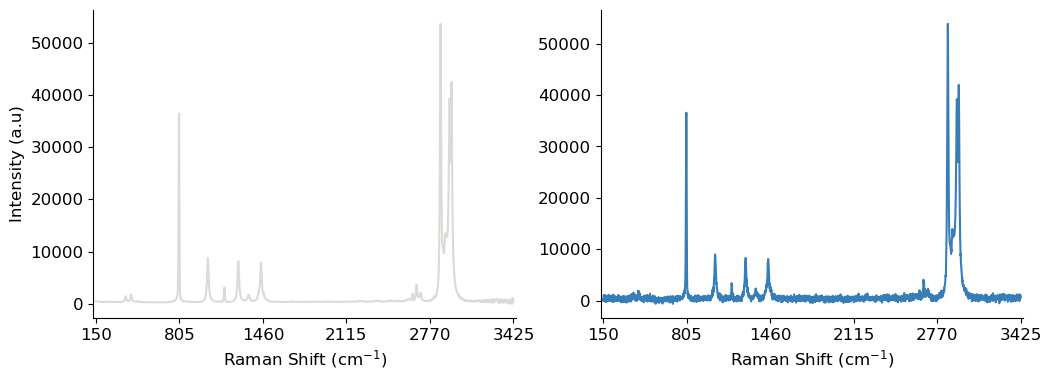

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].set_ylabel("Intensity (a.u)")
ax[0].plot(X_copy.loc[0], "#d8dcd6");
ax[1].plot(X_noisy.loc[0], "#377eb8")

for i in range(2):
    ax[i].spines['right'].set_color('none')
    ax[i].spines['top'].set_color('none')
    ax[i].spines['right'].set_color('none')
    ax[i].spines['top'].set_color('none')

    ax[i].set_xlabel("Raman Shift (cm$^{-1}$)")
    ax[i].set_xlim([-20, 3296])
    ax[i].set_xticks(xticks, labels=xlabels)

## Peak Shifting

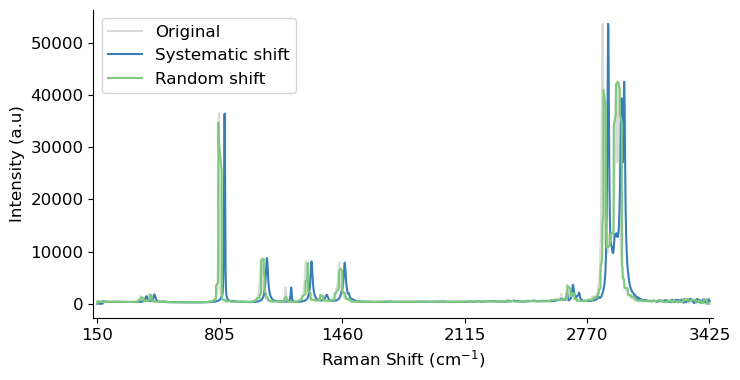

In [16]:
#wavenumbers = X.columns.astype(float).astype(int)
wavenumbers = np.linspace(150, 3425, 3276)

# Shift the wavenumbers amd interpolate the spectrum to the new wavenumber axis
shifted_sys_x = wavenumbers + 30
systematic_shift = np.interp(wavenumbers, shifted_sys_x, best_sample.reshape(-1), left=0, right=0)

# Random shift the wavenumbers
rand_shift_values = np.random.uniform(-15, 15, size=best_sample.reshape(-1).shape)
shifted_rand_x = wavenumbers + rand_shift_values
random_shift = np.interp(wavenumbers, shifted_rand_x, best_sample.reshape(-1), left=0, right=0)

_ = build_plot()
plt.plot(best_sample, "#d8dcd6", label="Original");
plt.plot(systematic_shift, "#377eb8", label="Systematic shift")
plt.plot(random_shift, "#7fc97f",  label="Random shift")
plt.legend();